In [1]:

%load_ext autoreload
%autoreload 2


In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "3"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

#RUN BEFORE#

In [3]:
#RUN AFTER#

import hls4ml
import pickle

from util.Models import *
from util.Generators import *
from util.Plotting import *


/home/joshualerner/start_tf/src/hls4ml/hls4ml/converters/__init__.py:25: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


In [4]:

data_path = '/fast_scratch_1/atlas_images/v01-45/'

cell_geo_path = data_path + 'cell_geo.root'

out_path = '/fast_scratch_1/jlerner/data/'

norm = 'log' # 'log', 'std', or 'max'
scaler = None

In [5]:

model = tf.keras.models.load_model(out_path + 'models/qGarNet_' + norm)

with open(out_path + 'models/qGarNet_' + norm + '/history.pickle', "rb") as file:
    history = pickle.load(file)

if norm == 'std':
    with open(out_path + 'models/qGarNet_' + norm + '/scaler.pickle', 'rb') as file:
        scaler = pickle.load(file)


2023-06-28 16:39:48.370300: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-06-28 16:39:48.370413: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1378 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3e:00.0, compute capability: 7.5


In [6]:
if norm == 'max':
    name = 'garnet_' + norm + '_2000'
else:
    name = 'garnet_' + norm

test_file_list = ([[data_path + f'pi0/user.angerami.24559740.OutputStream._000{i:03d}.root', 1] for i in range(232, 264)],
                  [[data_path + f'pipm/user.angerami.24559744.OutputStream._000{i:03d}.root', 0] for i in range(232, 264)])

test_generator = garnetDataGenerator(test_file_list,
                                     cell_geo_path,
                                     batch_size=20000,
                                     normalizer=(norm, scaler),
                                     name=name,
                                     labeled=True,
                                     preprocess=False,
                                     output_dir=out_path + 'test/')

x, y = next(test_generator.generator())

In [7]:
config = hls4ml.utils.config_from_keras_model(model, granularity='model')
config['Model']['Precision'] = 'ap_fixed<24, 8>'
config['LayerName'] = {'input_1': {'Precision': {'result': 'ap_fixed<18, 6, AP_RND, AP_SAT>'}},
                       'input_2': {'Precision': {'result': 'ap_uint<10>'}}}
config['LayerType'] = {'InputLayer': {'ReuseFactor': 1, 'Trace': False},
                       'GarNetStack': {'ReuseFactor': 1, 'Trace': True}, 
                       'Dense': {'ReuseFactor': 1, 'Trace': True},
                       'Activation': {'ReuseFactor': 1, 'Trace': False}}

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 128, 4]], output shape: [None, 128, 4]
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: garnet, layer type: GarNetStack, input shapes: [[None, 128, 4], [None, 1]], output shape: [None, 16]
Layer name: dense, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense_1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 8]
Layer name: classification, layer type: Dense, input shapes: [[None, 8]], output shape: [None, 2]
Layer name: regression, layer type: Dense, input shapes: [[None, 8]], output shape: [None, 1]


In [8]:
# config = {}

# config['Model'] = {'ReuseFactor': 1, 'Strategy': 'Latency', 'Precision': 'ap_fixed<18,6>'}

# config['LayerType'] = {'InputLayer': {'ReuseFactor': 1, 'Trace': False},
#                        'GarNetStack': {'ReuseFactor': 1, 'Trace': True}, 
#                        'Dense': {'ReuseFactor': 1, 'Trace': True},
#                        'Activation': {'ReuseFactor': 1, 'Trace': False}}

# config['LayerType']['GarNetStack']['Precision'] = {'default': 'ap_fixed<16, 6, AP_RND, AP_SAT>',
#                                                    'result': 'ap_fixed<18, 6, AP_RND, AP_SAT>'}

# config['LayerType']['Dense']['Precision'] = {'accum': 'ap_fixed<18, 8>',
#                                              'weight': 'ap_fixed<18, 6>',
#                                              'result': 'ap_fixed<18, 6, AP_RND, AP_SAT>'}

# config['LayerName'] = {'input_1': {'Precision': {'result': 'ap_fixed<14, 5, AP_RND, AP_SAT>'}},
#                        'input_2': {'Precision': {'result': 'ap_uint<10>'}},
#                        'classification': {'Precision': {'result': 'ap_fixed<16, 6, AP_RND, AP_SAT>'}},
#                        'regression': {'Precision': {'result': 'ap_fixed<16, 6, AP_RND, AP_SAT>'}}}


In [9]:
print("Configuration")
print("-----------------------------------")
config

Configuration
-----------------------------------


{'Model': {'Precision': 'ap_fixed<24, 8>',
  'ReuseFactor': 1,
  'Strategy': 'Latency',
  'BramFactor': 1000000000,
  'TraceOutput': False},
 'LayerName': {'input_1': {'Precision': {'result': 'ap_fixed<18, 6, AP_RND, AP_SAT>'}},
  'input_2': {'Precision': {'result': 'ap_uint<10>'}}},
 'LayerType': {'InputLayer': {'ReuseFactor': 1, 'Trace': False},
  'GarNetStack': {'ReuseFactor': 1, 'Trace': True},
  'Dense': {'ReuseFactor': 1, 'Trace': True},
  'Activation': {'ReuseFactor': 1, 'Trace': False}}}

In [10]:

hls_model = hls4ml.converters.convert_from_keras_model(model, hls_config=config, project_name='GarNetHLS',
                                                       output_dir='/home/joshualerner/start_tf/PionReconstruction/data/GarNetHLS/', 
                                                       part='xcku115-flvb2104-2-i')

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 128, 4]], output shape: [None, 128, 4]
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: garnet, layer type: GarNetStack, input shapes: [[None, 128, 4], [None, 1]], output shape: [None, 16]
Layer name: dense, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense_1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 8]
Layer name: classification, layer type: Dense, input shapes: [[None, 8]], output shape: [None, 2]
Layer name: regression, layer type: Dense, input shapes: [[None, 8]], output shape: [None, 1]
Creating HLS model


In [11]:
hls_model.compile()
keras_pred = model.predict(x)
hls_pred = hls_model.predict(x)

Writing HLS project
Done


2023-06-28 16:40:11.981487: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


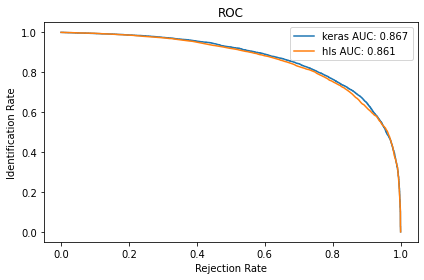

In [12]:
ROC = Plotter(roc, 
              preds=[keras_pred[0][:,0], hls_pred[0][:,0]],
              targets=[y['classification'][:,0], y['classification'][:,0]],
              labels=['keras', 'hls'])
ROC.show()

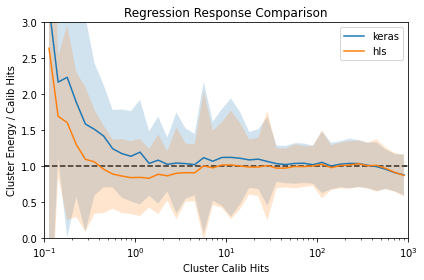

In [13]:
if norm == 'log':
    keras_scaled_pred = np.exp(keras_pred[-1]*10).reshape(-1,)
    hls_scaled_pred = np.exp(hls_pred[-1]*10).reshape(-1,)
    scaled_target = np.exp(y['regression']*10).reshape(-1,)
elif norm == 'std':
    keras_scaled_pred = scaler.inverse_transform(keras_pred[-1]).reshape(-1,)
    hls_scaled_pred = scaler.inverse_transform(hls_pred[-1]).reshape(-1,)
    scaled_target = scaler.inverse_transform(np.reshape(y['regression'], (-1, 1))).reshape(-1,)
elif norm == 'max':
    keras_scaled_pred = keras_pred[-1].reshape(-1,) * 2000
    hls_scaled_pred = hls_pred[-1].reshape(-1,) * 2000
    scaled_target = y['regression'].reshape(-1,) * 2000

reg = Plotter(regResponseOverlay, 
              preds=[keras_scaled_pred, hls_scaled_pred], 
              targets=[scaled_target, scaled_target],
              stat=['mean', 'stdmean'],
              labels=['keras', 'hls'])
reg.show()

Recompiling GarNetHLS with tracing
Writing HLS project
Done


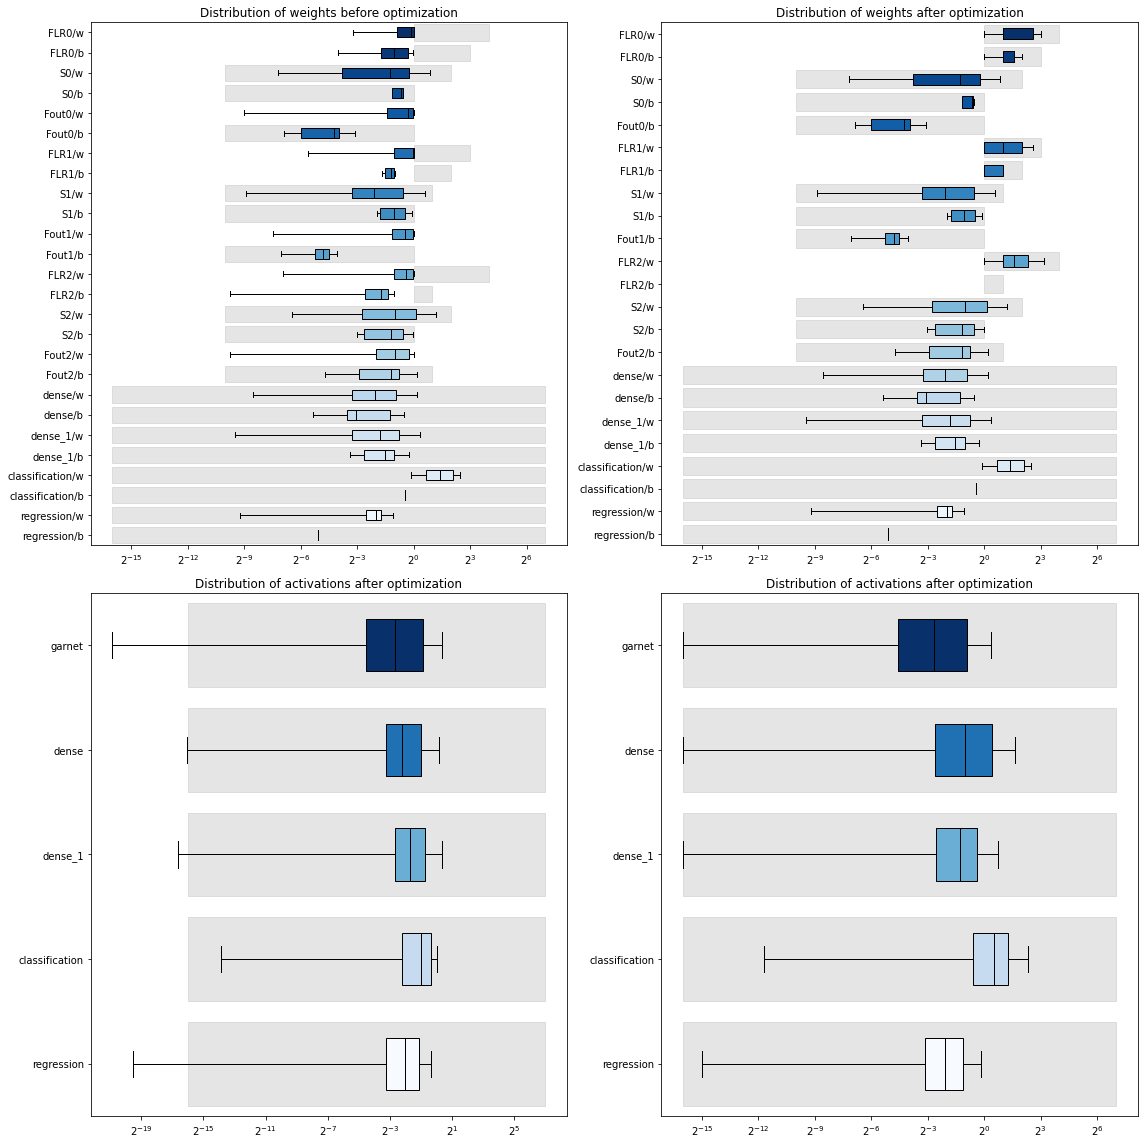

In [14]:
prof = Plotter(weight_profile, model=model, hls_model=hls_model, x=x)
prof.show()